In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf

In [2]:
start = 0
end = 100000

range_values = np.arange(start, end)

# Create the digit representation as a 2D array
X = np.array([list(map(int, str(x).zfill(15))) for x in range_values])

# Create the labels using vectorized operations
y = np.column_stack((range_values % 2, (range_values + 1) % 2))

# Split data up into training and validation data.
split_train = StratifiedShuffleSplit(n_splits=3, test_size=0.4, train_size=0.6)
for train_index, test_index in split_train.split(X, y):
    X_val, X_train = X[test_index], X[train_index]
    y_val, y_train = y[test_index], y[train_index]

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(70, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [46]:
#model.evaluate(X_train, y_train)

In [47]:
#model.evaluate(X_val, y_val)

In [ ]:
model.fit(X_train, y_train, batch_size=512, epochs=1000, validation_data=(X_val, y_val))

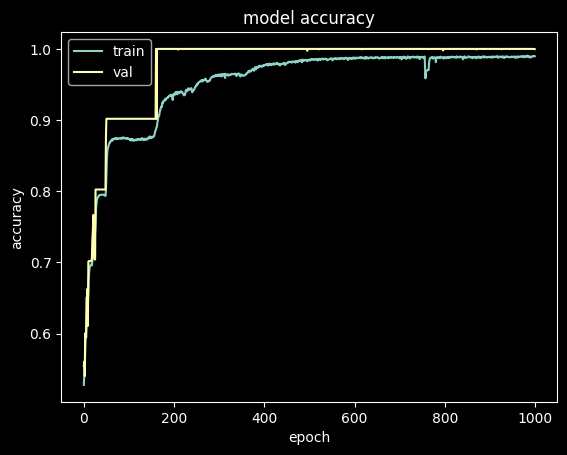

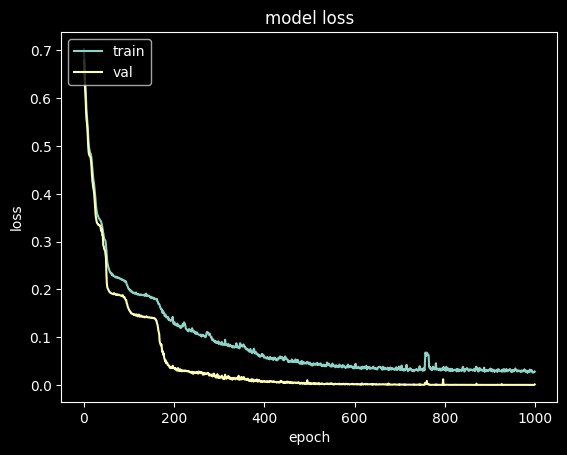

In [49]:
plt.style.use('dark_background')

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
print(model.history.history['val_accuracy'].index(max(model.history.history['val_accuracy'])))
print(max(model.history.history['val_accuracy']))
print(model.history.history['val_loss'].index(min(model.history.history['val_loss'])))
print(min(model.history.history['val_loss']))

160
1.0
995
0.00012220525240991265


In [51]:
#model.save('model.keras')